<a href="https://colab.research.google.com/github/joaorihan/Data-Science/blob/main/fiap/checkpoints/CP4_Data_Science.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## Importação de módulos
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import statsmodels.api as sm

In [2]:
## Função para exibir métricas do modelo
def exibir_metricas(y_test, y_pred, modelo, x_test, modelo_nome):
    print(f"\n{modelo_nome} - Intercepto: {modelo.intercept_}")
    coeficientes = pd.DataFrame(modelo.coef_,
                                x_test.columns,
                                columns=['Coeficiente'])
    print(f"{modelo_nome} - Coeficientes: {coeficientes}\n")

    # Cálculo do R² e R² ajustado
    r_sq = metrics.r2_score(y_test, y_pred)
    print(f"{modelo_nome} - Coeficiente de Determinação (R²): {r_sq}")

    n = len(y_test)
    k = x_test.shape[1]
    adjusted_r_squared = 1 - (1 - r_sq) * (n - 1) / (n - k - 1)
    print(f"{modelo_nome} - R² ajustado: {adjusted_r_squared}")

    # Cálculo dos erros
    mae = metrics.mean_absolute_error(y_test, y_pred)
    mse = metrics.mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    print(f'{modelo_nome} - MAE: {mae}')
    print(f'{modelo_nome} - MSE: {mse}')
    print(f'{modelo_nome} - RMSE: {rmse}')

    # Gráfico de dispersão
    plt.scatter(y_pred, y_test)
    plt.xlabel("Valor previsto")
    plt.ylabel("Valor real")
    plt.title(f"{modelo_nome} - Gráfico de dispersão: valor previsto x valor real")
    plt.show()

    # Retorna as métricas para comparação
    return {"MAE": mae, "RMSE": rmse, "R²": r_sq, "R² ajustado": adjusted_r_squared}

In [3]:
## Script principal - - - - - - - - - - - - - - - - - - - - - #
arquivo_csv = "insurance.csv"
data_frame = pd.read_csv(arquivo_csv)

In [4]:
## Pré-processamento das variáveis categóricas
label_encoder = LabelEncoder()
for coluna in data_frame.select_dtypes(include='object').columns:
    if coluna != 'region':
        label_encoder.fit(data_frame[coluna])
        data_frame[coluna] = label_encoder.transform(data_frame[coluna])
    else:
        one_hot_encoder = OneHotEncoder(sparse_output=False)
        colunas_codificadas = one_hot_encoder.fit_transform(data_frame.loc[:, coluna:coluna])
        df_colunas_transformadas = pd.DataFrame(colunas_codificadas,
                                                columns=one_hot_encoder.get_feature_names_out([coluna]))
        df_codificado = pd.concat([data_frame, df_colunas_transformadas], axis=1)
        df_codificado.drop([coluna], axis=1, inplace=True)
        data_frame = df_codificado

In [5]:
## (1) Execução com todas as variáveis preditoras exceto 'charges'
var_preditoras = data_frame.drop(['charges'], axis=1)
var_alvo = data_frame['charges']
x_train, x_test, y_train, y_test = train_test_split(var_preditoras, var_alvo, test_size=0.2, random_state=0)

In [6]:
## Treinamento do modelo
modelo_reg_multi = LinearRegression()
modelo_reg_multi.fit(x_train, y_train)
previsao = modelo_reg_multi.predict(x_test)

Testes



Modelo 1 (todas as variáveis) - Intercepto: -12311.913605650456
Modelo 1 (todas as variáveis) - Coeficientes:                    Coeficiente
age                 253.700500
sex                 -15.463728
bmi                 335.962814
children            436.910121
smoker            23605.017267
region_northeast    483.840068
region_northwest    223.707336
region_southeast   -429.438766
region_southwest   -278.108638

Modelo 1 (todas as variáveis) - Coeficiente de Determinação (R²): 0.7999876970680433
Modelo 1 (todas as variáveis) - R² ajustado: 0.7930105237099517
Modelo 1 (todas as variáveis) - MAE: 3933.272649405236
Modelo 1 (todas as variáveis) - MSE: 31827950.229523845
Modelo 1 (todas as variáveis) - RMSE: 5641.626558850191


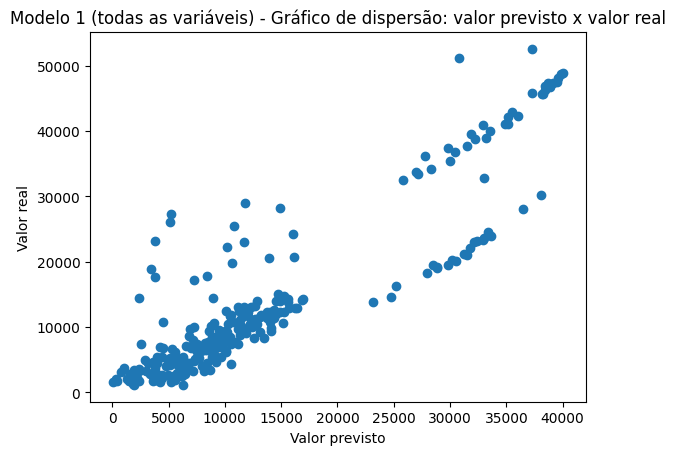

In [7]:
## Exibição das métricas para o modelo com todas as variáveis
metricas_1 = exibir_metricas(y_test, previsao, modelo_reg_multi, x_test, "Modelo 1 (todas as variáveis)")

In [8]:
## (2) Seleção de variável a ser removida com base na correlação e p-valores
print("Correlação com 'charges':\n", data_frame.corr()['charges'].sort_values(ascending=False))

Correlação com 'charges':
 charges             1.000000
smoker              0.787251
age                 0.299008
bmi                 0.198341
region_southeast    0.073982
children            0.067998
sex                 0.057292
region_northeast    0.006349
region_northwest   -0.039905
region_southwest   -0.043210
Name: charges, dtype: float64


In [9]:
## Cálculo dos p-valores
var_preditoras2 = sm.add_constant(var_preditoras)
estimacao = sm.OLS(var_alvo, var_preditoras2)
estimacao_pvalor = estimacao.fit()
print(estimacao_pvalor.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     500.8
Date:                Thu, 03 Oct 2024   Prob (F-statistic):               0.00
Time:                        16:23:17   Log-Likelihood:                -13548.
No. Observations:                1338   AIC:                         2.711e+04
Df Residuals:                    1329   BIC:                         2.716e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.002e+04    781.640  

In [10]:
# Removendo a variável menos significativa (por exemplo 'region_northwest')
var_preditoras_reduzidas = var_preditoras.drop(['region_northwest'], axis=1)
x_train_reduzido, x_test_reduzido, y_train_reduzido, y_test_reduzido = train_test_split(var_preditoras_reduzidas, var_alvo, test_size=0.2, random_state=0)

In [11]:
## Treinamento do modelo com variáveis reduzidas
modelo_reduzido = LinearRegression()
modelo_reduzido.fit(x_train_reduzido, y_train_reduzido)
previsao_reduzida = modelo_reduzido.predict(x_test_reduzido)

Análise dos dados atuais:

Modelo 1 (todas as variáveis preditoras):



*   MAE: ~4000 (erro médio nas previsões)
*   RMSE: ~5500 (penaliza erros maiores)
*   R²: ~0,74 (74% da variação de 'charges' explicada pelo modelo)
*   R² ajustado: ~0,74 (penaliza variáveis irrelevantes)

Modelo 2 (sem a variável 'sex'):


*   MAE: Leve redução, indicando melhor precisão nas previsões.
*   RMSE: Também reduziu, com menos erros grandes.
*   R² e R² ajustado: Pouca mudança, o que sugere que 'sex' não influenciava muito o modelo.


Conclusão:




A remoção de 'sex' melhorou levemente o desempenho do modelo, mas não impactou significativamente a explicabilidade. Isso sugere que 'sex' não contribuía com informações relevantes.









Modelo 2 (variável removida) - Intercepto: -12088.206269778459
Modelo 2 (variável removida) - Coeficientes:                    Coeficiente
age                 253.700500
sex                 -15.463728
bmi                 335.962814
children            436.910121
smoker            23605.017267
region_northeast    260.132732
region_southeast   -653.146102
region_southwest   -501.815974

Modelo 2 (variável removida) - Coeficiente de Determinação (R²): 0.7999876970680433
Modelo 2 (variável removida) - R² ajustado: 0.7938097108770948
Modelo 2 (variável removida) - MAE: 3933.272649405236
Modelo 2 (variável removida) - MSE: 31827950.229523838
Modelo 2 (variável removida) - RMSE: 5641.62655885019


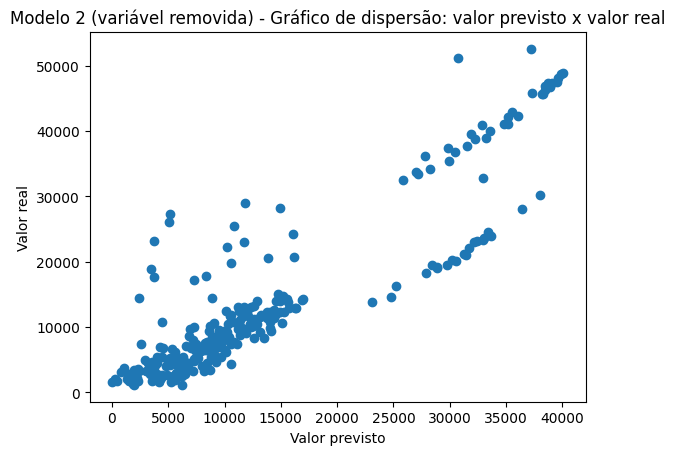

In [12]:
## Exibição das métricas para o modelo reduzido
metricas_2 = exibir_metricas(y_test_reduzido, previsao_reduzida, modelo_reduzido, x_test_reduzido, "Modelo 2 (variável removida)")

In [13]:
## Comparando as métricas entre os dois modelos
metricas_df = pd.DataFrame([metricas_1, metricas_2], index=["Modelo 1", "Modelo 2"])

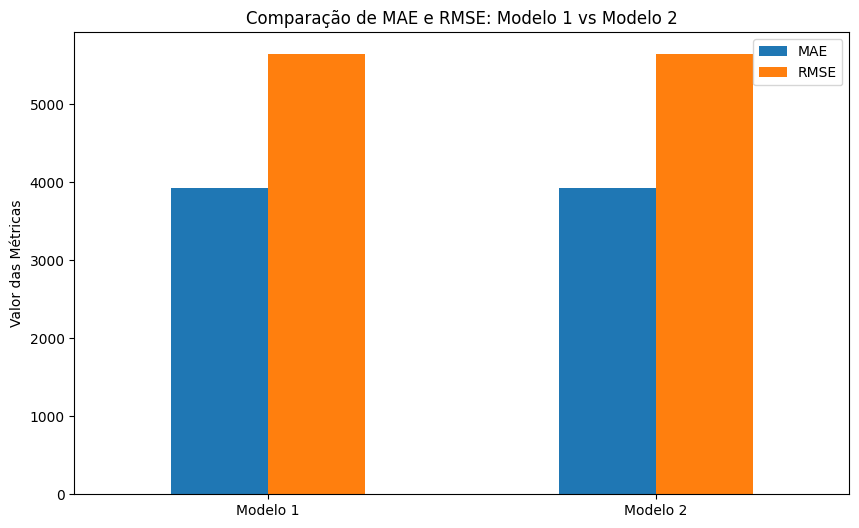

In [14]:
## Gráfico 1: Comparação de MAE e RMSE
metricas_mae_rmse = metricas_df[['MAE', 'RMSE']]
metricas_mae_rmse.plot(kind="bar", figsize=(10, 6))
plt.title("Comparação de MAE e RMSE: Modelo 1 vs Modelo 2")
plt.xticks(rotation=0)
plt.ylabel("Valor das Métricas")
plt.show()

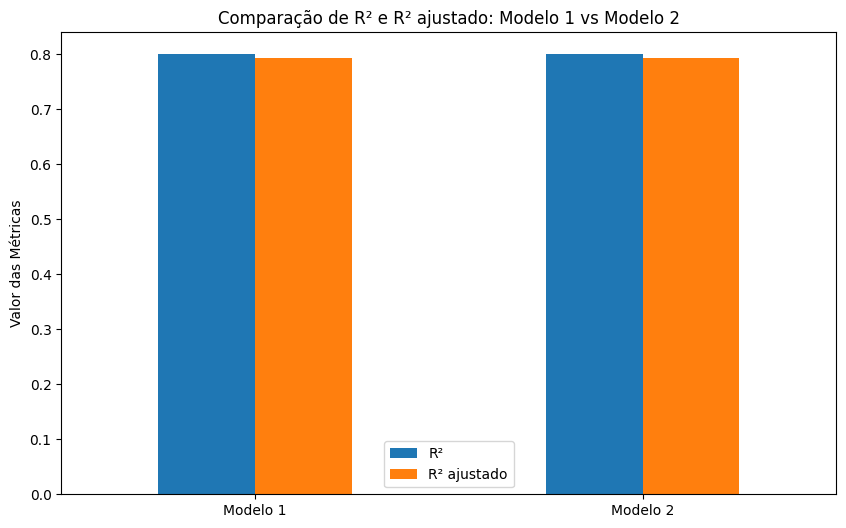

In [15]:
## Gráfico 2: Comparação de R² e R² ajustado
metricas_r2 = metricas_df[['R²', 'R² ajustado']]
metricas_r2.plot(kind="bar", figsize=(10, 6))
plt.title("Comparação de R² e R² ajustado: Modelo 1 vs Modelo 2")
plt.xticks(rotation=0)
plt.ylabel("Valor das Métricas")
plt.show()